### Prepare data

In [97]:
!pip install imageio_ffmpeg

import jax
import jax.numpy as jnp
from jax import jit, grad, random
from jax.experimental import stax, optimizers

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import imageio
import itertools
import numpy

from IPython.display import HTML
from base64 import b64encode

# Create a pseudo-random number generator (PRNG) key given an integer seed.
rand_key = random.PRNGKey(0)

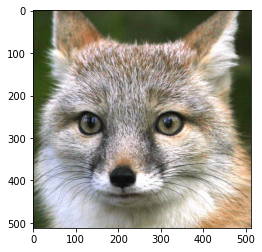

In [98]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg' # originally (689, 1024, 3)
img = imageio.imread(image_url) / 255. # normalize
center = [ img.shape[0]//2 , img.shape[1]//2 ] # get center pixel coordinate (x, y)
img_halfWidth = 256 # width & height, we choose a even number
img_width = img_halfWidth * 2
img = img[ center[0]-img_halfWidth:center[0]+img_halfWidth , center[1]-img_halfWidth:center[1]+img_halfWidth ] # crop to a square size

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = jnp.linspace(0, 1, img_width, endpoint=False)
x_test = jnp.stack(jnp.meshgrid(coords, coords), -1) # get grid sample points coodinates

img_original_shape = img.shape

# X: pt_related, Y: rgb
X_test = x_test.reshape(-1, 2)
Y_test = img.reshape(-1, 3) 
X_train = x_test[::2,::2].reshape(-1, 2)
Y_train = img[::2,::2].reshape(-1, 3)

### Define model & Functions

In [99]:
@jit
def Count_num_params(tree):
    '''
    input: a pytree
    output: # of params
    '''
    return sum(x.size for x in jax.tree_leaves(tree))

def Count_num_cornerFeatures(layer_params_list):
    '''
    input: list of layer_params (each element is a dict of layer_params), `params['Features']`
    output # of cornerFeatures
    '''
    total_num_cornerFeatures = 0
    for layer_params in layer_params_list:
        total_num_cornerFeatures += layer_params['cornerFeatures'].shape[0]
    
    return total_num_cornerFeatures


def Gen_mp4(imgs):
    '''
    input: a list of imgs
    output: url of mp4
    '''
    data8 = (255*jnp.clip(jnp.array(imgs),0,1)).astype(jnp.uint8)
    f = os.path.join('my_training_convergence.mp4')
    imageio.mimwrite(f, data8, fps=10)

    # Display video inline
    mp4 = open(f,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return data_url

In [100]:

@jit
def Bilinear_interpolate(layer_params, layer_info, pt_related):
    '''
        input 
            layer_params: params of a single featureLayer 
            layer_info: info, shape, etc. of the featureLayer
            pt_related: a point coordinate (x, y), where 0 <= x,y <= 1
        output 
            interpolated feature
    '''

    depth = layer_info['depth']
    cornerFeatures = layer_params['cornerFeatures']
    invert_lookup_table = layer_info['invert_lookup_table']

    pt_scaled = jnp.array(pt_related) * (2 ** depth)
    features_ul_idx = jnp.floor(pt_scaled).astype(int)
    features_ul_idx = jnp.clip(features_ul_idx, 0, (2**depth-1)) # boundary condition
    features_ul_idx_flatten = features_ul_idx[..., 1] * (2**depth+1) + features_ul_idx[..., 0]

    features_ul = cornerFeatures[invert_lookup_table[features_ul_idx_flatten]]
    features_ur = cornerFeatures[invert_lookup_table[features_ul_idx_flatten + 1]]
    features_dl = cornerFeatures[invert_lookup_table[features_ul_idx_flatten + (2**depth+1)]]
    features_dr = cornerFeatures[invert_lookup_table[features_ul_idx_flatten + (2**depth+1) + 1]]
    
    dist_up = pt_scaled[..., 1] - features_ul_idx[..., 1]
    dist_down  = 1. - dist_up
    dist_left = pt_scaled[..., 0] - features_ul_idx[..., 0]
    dist_right = 1. - dist_left
    
    interpolated_up   = (features_ul.T * dist_right).T + (features_ur.T * dist_left).T
    interpolated_down = (features_dl.T * dist_right).T + (features_dr.T * dist_left).T
    features_q = (interpolated_up.T * dist_down).T + (interpolated_down.T * dist_up).T

    # if a query point is not in blocks, make its features to [nan, nan, ... , nan]
    whetherInBlocks = IsInFeatureLayer(layer_params, layer_info, pt_related)
    mask = jnp.full(len(pt_related), jnp.nan) * jnp.invert(whetherInBlocks) + whetherInBlocks
    features_q = (features_q.T * mask).T
    
    return features_q

In [101]:
def New_featureLayer(depth, unqualified_parent_blocks_idx_flatten, features_dim, rand_key, parent_layer_params, parent_layer_info):
    '''
        depth: (int)depth of the tree
        unqualified_parent_blocks_idx_flatten: (jnp.array)the blocks which need to add next-level features, flatten idx 
        features_dim: (int)dimension of a feature vector
        rand_key: random seed
        parent_layer_params: layer_params of parent
        parent_layer_info: layer_info of parent

        return 
            layer_params: params of this new featureLayer
                cornerFeatures: (jnp.array)a 2D jnp array, each row is a `features-dim` vector
            layer_info: info, shape, etc. of this new featureLayer
                depth: (int) depth of the layer
                blocks_idx_flatten: (jnp.array)index of blocks existing in this layer (flatten index, row major)
                invert_lookup_table: (jnp.array)for looking up which cornerFeatures to use, input flatten block indexes output idx of corresponding cornerFeatures
    '''
    layer_info = dict()
    layer_params = dict()

    # init depth
    layer_info['depth'] = depth
    
    # init blocks
    if depth == 0: # boundary condition
        layer_info['blocks_idx_flatten'] = jnp.array([0])
    else:
        # for each parent_blocks (x,y) add {2x, 2x+1}x{2y, 2y+1}
        px = unqualified_parent_blocks_idx_flatten %  (2 ** (depth-1)) #unflatten
        py = unqualified_parent_blocks_idx_flatten // (2 ** (depth-1))
        px_base = jnp.array([2*px, 2*px+1]).T # add elements
        py_base = jnp.array([2*py, 2*py+1]).T
        px_align = jnp.repeat(px_base, py_base.shape[-1], axis=1) # repeat
        py_align = jnp.tile(py_base, px_base.shape[-1])
        merge = jnp.array([px_align, py_align]) 
        cartesian_product = jnp.transpose(merge, (1, 2, 0)).reshape(-1, 2) # get product of px_base & py_base
        product_unique = jnp.unique(cartesian_product, axis=0) # eliminate duplicates
        layer_info['blocks_idx_flatten'] = product_unique[..., 1] * (2**depth) + product_unique[..., 0]
        layer_info['blocks_idx_flatten'] = jnp.sort(layer_info['blocks_idx_flatten'])
    
    # init cornerFeatures - invert_lookup_table
    if depth == 0: # boundary condition
        cornerFeatures_idx_flatten = jnp.array([0, 1, 2, 3])
    else:
        # for each parent_blocks (x,y) add {2x, 2x+1, 2x+2}x{2y, 2y+1, 2y+2}
        px = unqualified_parent_blocks_idx_flatten %  (2 ** (depth-1))
        py = unqualified_parent_blocks_idx_flatten // (2 ** (depth-1))
        px_base = jnp.array([2*px, 2*px+1, 2*px+2]).T
        py_base = jnp.array([2*py, 2*py+1, 2*py+2]).T
        px_align = jnp.repeat(px_base, py_base.shape[-1], axis=1)
        py_align = jnp.tile(py_base, px_base.shape[-1])
        merge = jnp.array([px_align, py_align])
        cartesian_product = jnp.transpose(merge, (1, 2, 0)).reshape(-1, 2)
        product_unique = jnp.unique(cartesian_product, axis=0)
        product_unique = jnp.array( sorted(product_unique, key=lambda x: (x[1], x[0])) )
        sample_pt_related = product_unique / (2 ** depth) # later use for init cornerFeatures
        cornerFeatures_idx_flatten = product_unique[..., 1] * (2**depth + 1) + product_unique[..., 0]
        cornerFeatures_idx_flatten = jnp.sort(cornerFeatures_idx_flatten)

    num_cornerFeatures = len(cornerFeatures_idx_flatten)

    invert_table = numpy.full((2**depth + 1) ** 2, jnp.nan, dtype=int)
    for i in range(len(cornerFeatures_idx_flatten)):
        invert_table[cornerFeatures_idx_flatten[i]] = i
    layer_info['invert_lookup_table'] = jnp.array(invert_table)

    # init cornerFeatures - cornerFeatures
    if depth == 0: # boundary condition
        layer_params['cornerFeatures'] = random.normal(rand_key, (num_cornerFeatures,features_dim))
    else:
        layer_params['cornerFeatures'] = Bilinear_interpolate(parent_layer_params, parent_layer_info, sample_pt_related)
        



    return layer_params, layer_info


@jit
def IsInFeatureLayer(layer_params, layer_info, pt_related):
    '''
        input
            layer_params: params of a single featureLayer 
            layer_info: info, shape, etc. of the featureLayer
            pt_related: a point coordinate (x, y), where 0 <= x,y <= 1, accept batch[[x1 y1], [x2 y2], ...]
        output 
            whether this point is inside this featureLayer
    '''
    
    # get blocks that contain the pts, flatten idx of blocks, row major
    depth = layer_info['depth']
    pt_scaled = pt_related * (2 ** depth)
    pt_blocks = jnp.floor(pt_scaled).astype(int)
    pt_blocks = jnp.clip(pt_blocks, 0, (2**depth-1)) # boundary condition
    pt_blocks_flatten = pt_blocks[..., 1] * (2**depth) + pt_blocks[..., 0]

    # return whether each pt is in the blocks
    return jnp.in1d(pt_blocks_flatten, layer_info['blocks_idx_flatten'])




In [102]:
@jit
def Get_deepest_features(layer_params_list, layer_info_list, pt_related):
    '''
        input
            layer_params_list: params of all featureLayer 
            layer_info_list: info, shape, etc. of all featureLayer
            pt_related: a point coordinate (x, y), where 0 <= x,y <= 1
        output
            features vector of pt_related
    '''
    each_layer_features = list()
    for i in range(len(layer_params_list)):
        layer_features = Bilinear_interpolate(layer_params_list[i], layer_info_list[i], pt_related)
        each_layer_features.append(layer_features)
    each_pt_features = jnp.stack(each_layer_features, axis=1)
    
    # find idx(mask) of deepest layer for each queried point
    TFmap = ~jnp.isnan(each_pt_features)
    TFmap_shiftL_invert = ~jnp.concatenate((TFmap[:, 1:, :], jnp.zeros((each_pt_features.shape[0],1,each_pt_features.shape[2])).astype(bool)), 
                                   axis=-2)
    mask = TFmap & TFmap_shiftL_invert

    #return each_pt_features[mask]
    return jnp.sum(each_pt_features * mask, axis=-2)


### Config hyperparameters & Training


In [117]:
####################### Change Here #########################

# hyperparameters
features_dim = 5 
mlp_shape = (16, 16, 16, 3)
numEpoch = 2500 
learning_rate = 5e-3

MAX_LOD = 7     #LOD=1 has only 4 cornerFeatures

PSNR_threshold = 23.

ratio_normLoss = 0.1

#############################################################


# MLP
mlp_layers = []
for i in range(len(mlp_shape)-1):
    mlp_layers.append(stax.Dense(mlp_shape[i]))
    mlp_layers.append(stax.Relu)
mlp_layers.append(stax.Dense(mlp_shape[-1])) # output layer
mlp_layers.append(stax.Sigmoid)
MLP_init, MLP_apply = stax.serial(*mlp_layers)


# Features
layer_params_list = list()
layer_info_list = list()
rand_key, subkey = random.split(rand_key, num=2) 
layer_params, layer_info = New_featureLayer(depth=0, unqualified_parent_blocks_idx_flatten=None, features_dim=features_dim, rand_key=subkey, 
                                            parent_layer_params=None, parent_layer_info=None)
layer_params_list.append(layer_params)
layer_info_list.append(layer_info)


# params
params = dict()
rand_key, subkey = random.split(rand_key, num=2)
_out_shape, MLP_params = MLP_init(subkey, (-1, features_dim)) 
params['MLP'] = MLP_params
params['Features'] = layer_params_list

print('# params in Features:', Count_num_params(params['Features']))
print('# params in MLP:', Count_num_params(params['MLP']))
print('# total params:', Count_num_params(params))
print('# cornerFeatures:', Count_num_cornerFeatures(params['Features']))


# params in Features: 20
# params in MLP: 691
# total params: 711
# cornerFeatures: 4


In [118]:
# define forward pass
@jit
def model_pred(params, layer_info_list, X):
    '''
        input
            params: params of features(layers_params) & MLP
            layer_info_list: info, shape, etc. of all featureLayer
            X: batch pt_related
        output
            batch Y_pred
    '''

    features = Get_deepest_features(params['Features'], layer_info_list, X)
    Y_pred = MLP_apply(params['MLP'], features)
    return Y_pred


# define loss & loss_grad
@jit
def model_loss(params, layer_info_list, X, Y, ratio_normLoss):

    # add reconstruct (PSNR...) loss
    Loss = 0.5 * jnp.mean(( model_pred(params, layer_info_list, X) - Y ) ** 2)
    
    # add cornerFeatures norm loss
    norm_loss = 0.
    layer_params_list = params['Features']
    for layer_params in layer_params_list:
        cornerFeatures = layer_params['cornerFeatures']
        cornerFeatures_norm = jnp.linalg.norm(cornerFeatures, axis=-1, ord=2)
        norm_loss += jnp.mean( (cornerFeatures_norm - 1.) ** 2 ) # norm = 1 is the best
    norm_loss /= len(layer_params_list)

    Loss += ratio_normLoss * norm_loss

    return Loss

model_loss_value_and_grad = jit(jax.value_and_grad(model_loss))


# define psnr
@jit
def cal_psnr(params, layer_info_list, X, Y):
    return -10 * jnp.log10(     jnp.mean( (model_pred(params, layer_info_list, X) - Y)**2)        )




# define optimizer
optim_init, optim_update, get_params = optimizers.adam(step_size=learning_rate)
optim_update = jit(optim_update)
optim_state = optim_init(params)


In [119]:

def find_unqualified_blocks(params, layer_info_list, X, Y, PSNR_threshold):
    '''
    input
        params: params of features(layers_params) & MLP
        layer_info_list: info, shape, etc. of all featureLayer
        X: batch pt_related, flatten
        Y: batch groundtruth, flatten
        PSNR_threshold: threshold of PSNR
    output
        idx of blocks that any X point inside has PSNR < PSNR_threshold (flatten blocks idx of last (deepest) layer)
    '''
    last_layer_info = layer_info_list[-1]
    depth = last_layer_info['depth']
    blocks_idx_flatten = last_layer_info['blocks_idx_flatten']

    numRow = jnp.sqrt(X.shape[0]).astype(int) # num of rows = num of columns, for X & Y
    numPartitionInRow = 2**depth # num partition of rows & columns, total numPartitionInRow^2 sub-matrices
    numRowInEachPartition = jnp.array(numRow / numPartitionInRow).astype(int)

    X_2D = X.reshape(numRow, numRow, 2)
    Y_2D = Y.reshape(numRow, numRow, 3)

    X_2D_split_col   = jnp.array(jnp.array_split(X_2D          , jnp.array(range(numRowInEachPartition, numRow, numRowInEachPartition)), axis=1))
    X_2D_submatrices = jnp.array(jnp.array_split(X_2D_split_col, jnp.array(range(numRowInEachPartition, numRow, numRowInEachPartition)), axis=1))
    Y_2D_split_col   = jnp.array(jnp.array_split(Y_2D          , jnp.array(range(numRowInEachPartition, numRow, numRowInEachPartition)), axis=1))
    Y_2D_submatrices = jnp.array(jnp.array_split(Y_2D_split_col, jnp.array(range(numRowInEachPartition, numRow, numRowInEachPartition)), axis=1))

    # each entry i in this array is a batch training data for block i (flatten idx)
    X_each_block = X_2D_submatrices.reshape(numPartitionInRow**2, numRowInEachPartition**2, 2) # all blocks
    Y_each_block = Y_2D_submatrices.reshape(numPartitionInRow**2, numRowInEachPartition**2, 3)
    X_each_block_exist = X_each_block[blocks_idx_flatten] # only existing blocks
    Y_each_block_exist = Y_each_block[blocks_idx_flatten]

    # get Y_pred of each exist block
    X_each_block_exist_flatten = X_each_block_exist.reshape(-1, 2)
    Y_pred_each_block_exist_flatten = model_pred(params, layer_info_list, X_each_block_exist_flatten)
    Y_pred_each_block_exist = Y_pred_each_block_exist_flatten.reshape(Y_each_block_exist.shape)
    #print(numRow, numRowInEachPartition)
    #print(Y_pred_each_block_exist.shape)

    # cal psnr of each exist block each X point inside
    psnr_each_block_each_Xpoint_exist = -10 * jnp.log10( jnp.mean( (Y_pred_each_block_exist - Y_each_block_exist)**2 , axis=(2)) )
    return blocks_idx_flatten[ jnp.any(psnr_each_block_each_Xpoint_exist < PSNR_threshold, axis=-1)]

In [120]:
#x = jnp.array([[1, 0], [0, 1], [0.7, 0.7], [0.5, 0.85]])
#print(jnp.linalg.norm(x, axis=-1, ord=2))

#print(jnp.sqrt((x[:,1]*x[:,1] + x[:,0]*x[:,0])))


In [121]:
# training
train_psnrs = []
test_psnrs = []
pred_imgs = []
loss_logs = []
xs = []
for i in tqdm(range(numEpoch), leave=False):
    loss_value, grads = model_loss_value_and_grad( get_params(optim_state), layer_info_list, X_train, Y_train, ratio_normLoss)
    optim_state = optim_update(i, grads, optim_state)
    
    if i % 25 == 0:
        train_psnrs.append(cal_psnr(get_params(optim_state), layer_info_list, X_train, Y_train))
        test_psnrs.append(cal_psnr(get_params(optim_state), layer_info_list, X_test, Y_test))
        pred_imgs.append( (model_pred(get_params(optim_state), layer_info_list, X_test)).reshape(img_original_shape) )
        loss_logs.append(loss_value)
        xs.append(i)

    if (i % 250 == 0) and (len(layer_info_list)+1 <= MAX_LOD):
        # check if we need to add next layer
        unqualified_blocks = find_unqualified_blocks(get_params(optim_state), layer_info_list, X_train, Y_train, PSNR_threshold)
        if (len(unqualified_blocks) > 0): 
            # allocate new layer
            print(f'blocks {unqualified_blocks} are unqualified (total {unqualified_blocks.shape[0]} blocks), add layer depth {len(layer_info_list)}')
            rand_key, subkey = random.split(rand_key, num=2) 
            layer_params, layer_info = New_featureLayer( depth=len(layer_info_list), 
                                                        unqualified_parent_blocks_idx_flatten=unqualified_blocks,
                                                        features_dim=features_dim, 
                                                        rand_key=subkey, 
                                                        parent_layer_params=get_params(optim_state)['Features'][-1],
                                                        parent_layer_info=layer_info_list[-1])
            
            # update params
            params = get_params(optim_state)
            params['Features'].append(layer_params)
            layer_info_list.append(layer_info)
    
            # update optimizer
            #optim_init, optim_update, get_params = optimizers.adam(step_size=learning_rate)
            #optim_update = jit(optim_update) # do we need to write it again??
            optim_state = optim_init(params)

            print('# params in Features:', Count_num_params(get_params(optim_state)['Features']))
            print('# params in MLP:', Count_num_params(get_params(optim_state)['MLP']))
            print('# total params:', Count_num_params(get_params(optim_state)))
            print('# cornerFeatures:', Count_num_cornerFeatures(get_params(optim_state)['Features']))
            print(f'now LOD={len(layer_info_list)}')
            print('\n')

  0%|          | 0/2500 [00:00<?, ?it/s]

blocks [0] are unqualified (total 1 blocks), add layer depth 1
# params in Features: 65
# params in MLP: 691
# total params: 756
# cornerFeatures: 13
now LOD=2


blocks [0 1 2 3] are unqualified (total 4 blocks), add layer depth 2
# params in Features: 190
# params in MLP: 691
# total params: 881
# cornerFeatures: 38
now LOD=3


blocks [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] are unqualified (total 16 blocks), add layer depth 3
# params in Features: 595
# params in MLP: 691
# total params: 1286
# cornerFeatures: 119
now LOD=4


blocks [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63] are unqualified (total 63 blocks), add layer depth 4
# params in Features: 2030
# params in MLP: 691
# total params: 2721
# cornerFeatures: 406
now LOD=5


blocks [  1   2   3   4  12  13  14  15  17  18  19  20  21  27  28  29  30  31
  33  34  35  36  37 

### Show result

In [122]:
train_psnrs = jnp.array(train_psnrs)
test_psnrs = jnp.array(test_psnrs)
pred_imgs = jnp.array(pred_imgs)
loss_logs = jnp.array(loss_logs)
xs = jnp.array(xs)

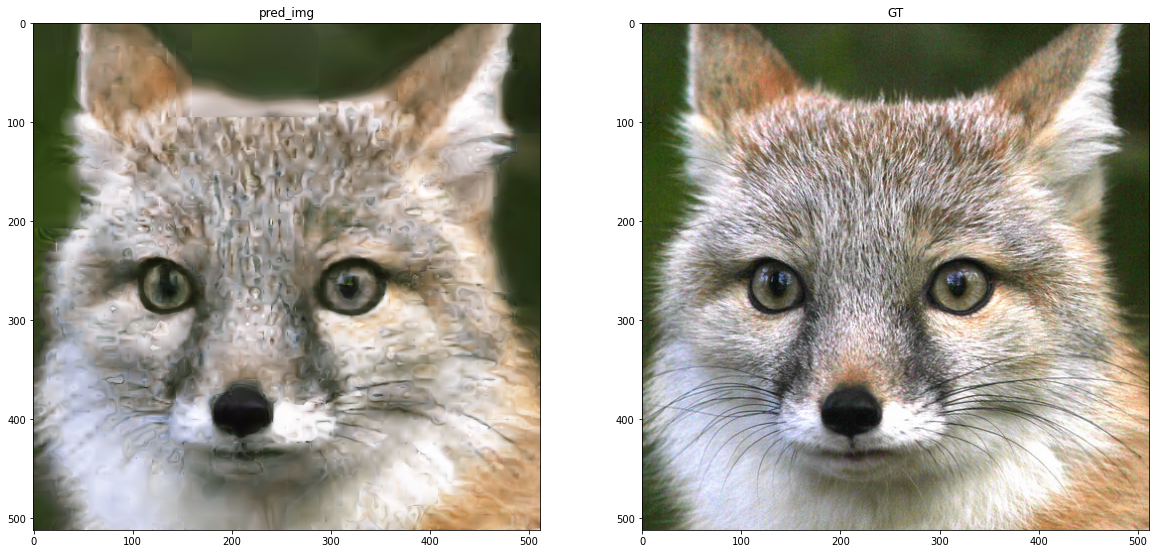

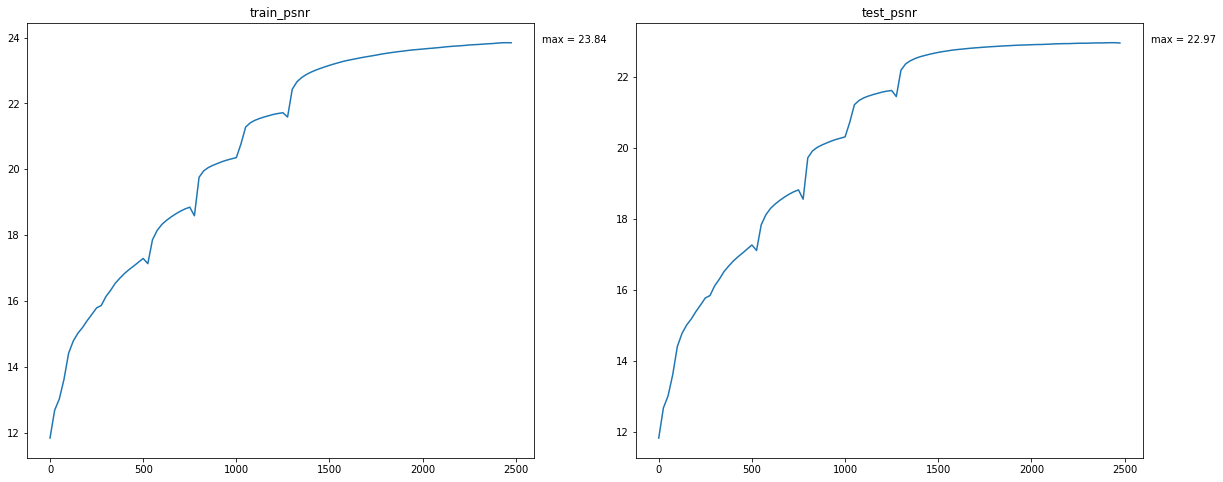

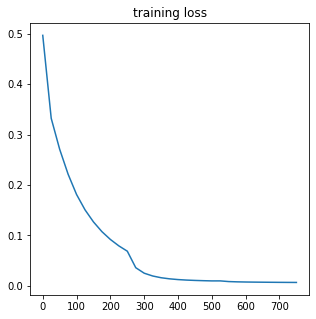

In [123]:
# show results
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(pred_imgs[-1])
plt.title('pred_img')

plt.subplot(1,2,2)
plt.imshow(img)
plt.title('GT')
plt.show()


plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(xs, train_psnrs)
plt.title('train_psnr')
plt.annotate(f'max = {train_psnrs.max():0.2f}' , xy=(1, train_psnrs.max()), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')

plt.subplot(1,2,2)
plt.plot(xs, test_psnrs)
plt.title('test_psnr')
plt.annotate(f'max = {test_psnrs.max():0.2f}' , xy=(1, test_psnrs.max()), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.show()



plt.figure(figsize=(5,5))
plt.plot(xs, loss_logs)
plt.title('training loss')
plt.annotate(f'max = {loss_logs.min():0.5f}' , xy=(1, loss_logs.min()), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.show()


data_url = Gen_mp4(pred_imgs)
HTML(f'''
    <video width=300 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    ''')

### Backup

In [124]:
# parallel gen next layer set
'''depth = 2
idx_f = jnp.array([0,3])


px = idx_f %  (2 ** (depth-1))
py = idx_f // (2 ** (depth-1))

#ppx = jnp.array([2*px, 2*px+1]).T
#ppy = jnp.array([2*py, 2*py+1]).T
ppx = jnp.array([2*px, 2*px+1, 2*px+2]).T
ppy = jnp.array([2*py, 2*py+1, 2*px+2]).T

p = jnp.repeat(ppx, ppy.shape[-1], axis=1)
q = jnp.tile(ppy, ppx.shape[-1])
t = jnp.array([p, q])
product = jnp.transpose(t, (1, 2, 0)).reshape(-1, 2)
product_unique = jnp.unique(product, axis=0)
print(product_unique)

#x = product_unique[..., 1] * (2**depth) + product_unique[..., 0]
x = product_unique[..., 1] * (2**depth + 1) + product_unique[..., 0]
print(x)'''

'depth = 2\nidx_f = jnp.array([0,3])\n\n\npx = idx_f %  (2 ** (depth-1))\npy = idx_f // (2 ** (depth-1))\n\n#ppx = jnp.array([2*px, 2*px+1]).T\n#ppy = jnp.array([2*py, 2*py+1]).T\nppx = jnp.array([2*px, 2*px+1, 2*px+2]).T\nppy = jnp.array([2*py, 2*py+1, 2*px+2]).T\n\np = jnp.repeat(ppx, ppy.shape[-1], axis=1)\nq = jnp.tile(ppy, ppx.shape[-1])\nt = jnp.array([p, q])\nproduct = jnp.transpose(t, (1, 2, 0)).reshape(-1, 2)\nproduct_unique = jnp.unique(product, axis=0)\nprint(product_unique)\n\n#x = product_unique[..., 1] * (2**depth) + product_unique[..., 0]\nx = product_unique[..., 1] * (2**depth + 1) + product_unique[..., 0]\nprint(x)'

In [125]:
# invert table
'''
import numpy

depth = 1


mydict = {(0,0): jnp.array([0,2,3,4,5]), 
     (1,0): jnp.array([1,2,3,4,5]),
     (0,1): jnp.array([3,2,3,4,5]),
     (1,1): jnp.array([4,2,3,4,5]),
     (2,1): jnp.array([5,2,3,4,5]),
     (1,2): jnp.array([7,2,3,4,5]),
     (2,2): jnp.array([8,2,3,4,5])
     }

# construct invert_table & corner_features array
my_dict_list = numpy.array(list(mydict.items()), dtype=object)

corner_features = jnp.array(list(my_dict_list[:,1]))

corner_index = jnp.array(list(my_dict_list[:,0]))
corner_index_flatten = corner_index[..., 1] * (2**depth + 1) + corner_index[..., 0]
invert_table = numpy.full((2**depth + 1) ** 2, jnp.nan, dtype=int)
for i in range(len(corner_index_flatten)):
    invert_table[corner_index_flatten[i]] = i
invert_table = jnp.array(invert_table)
print(invert_table)




target_idx = jnp.array([[1,2], [0,1], [1,2], [0,0]])
target_idx_flatten = target_idx[..., 1] * (2**depth + 1) + target_idx[..., 0]

corner_features[invert_table[target_idx_flatten]]
'''

'\nimport numpy\n\ndepth = 1\n\n\nmydict = {(0,0): jnp.array([0,2,3,4,5]), \n     (1,0): jnp.array([1,2,3,4,5]),\n     (0,1): jnp.array([3,2,3,4,5]),\n     (1,1): jnp.array([4,2,3,4,5]),\n     (2,1): jnp.array([5,2,3,4,5]),\n     (1,2): jnp.array([7,2,3,4,5]),\n     (2,2): jnp.array([8,2,3,4,5])\n     }\n\n# construct invert_table & corner_features array\nmy_dict_list = numpy.array(list(mydict.items()), dtype=object)\n\ncorner_features = jnp.array(list(my_dict_list[:,1]))\n\ncorner_index = jnp.array(list(my_dict_list[:,0]))\ncorner_index_flatten = corner_index[..., 1] * (2**depth + 1) + corner_index[..., 0]\ninvert_table = numpy.full((2**depth + 1) ** 2, jnp.nan, dtype=int)\nfor i in range(len(corner_index_flatten)):\n    invert_table[corner_index_flatten[i]] = i\ninvert_table = jnp.array(invert_table)\nprint(invert_table)\n\n\n\n\ntarget_idx = jnp.array([[1,2], [0,1], [1,2], [0,0]])\ntarget_idx_flatten = target_idx[..., 1] * (2**depth + 1) + target_idx[..., 0]\n\ncorner_features[inver

In [126]:
# parallel interpolate

'''
layer_params, layer_info = New_featureLayer(depth=2, unqualified_parent_blocks_idx_flatten=jnp.array([0,3]), features_dim=5, rand_key=rand_key, init_cornerFeatures=None)
pt_related = jnp.array([[0.1, 0.1], [0.8, 0.1], [0.2, 0.7], [0.9, 0.8]])
#print('\nblocks_idx_flatten:\n', layer_info['blocks_idx_flatten'])
#print('\ninvert_lookup_table:\n', layer_info['invert_lookup_table'])




whetherInBlocks = IsInFeatureLayer(layer_params, layer_info, pt_related)
#print('\nwhetherInBlocks:\n', whetherInBlocks)


depth = layer_info['depth']
cornerFeatures = layer_params['cornerFeatures']
invert_lookup_table = layer_info['invert_lookup_table']

pt_scaled = jnp.array(pt_related) * (2 ** depth)
features_ul_idx = jnp.floor(pt_scaled).astype(int)
#print('\npt_blocks_idx_flatten:\n', features_ul_idx[..., 1] * (2**depth) + features_ul_idx[..., 0])

features_ul_idx_flatten = features_ul_idx[..., 1] * (2**depth+1) + features_ul_idx[..., 0]



features_ul = cornerFeatures[invert_lookup_table[features_ul_idx_flatten]]
features_ur = cornerFeatures[invert_lookup_table[features_ul_idx_flatten + 1]]
features_dl = cornerFeatures[invert_lookup_table[features_ul_idx_flatten + (2**depth+1)]]
features_dr = cornerFeatures[invert_lookup_table[features_ul_idx_flatten + (2**depth+1) + 1]]

dist_up = pt_scaled[..., 1] - features_ul_idx[..., 1]
dist_down  = 1. - dist_up
dist_left = pt_scaled[..., 0] - features_ul_idx[..., 0]
dist_right = 1. - dist_left

interpolated_up   = (features_ul.T * dist_right).T + (features_ur.T * dist_left).T
interpolated_down = (features_dl.T * dist_right).T + (features_dr.T * dist_left).T
features_q = (interpolated_up.T * dist_down).T + (interpolated_down.T * dist_up).T

#print('\nfeatures_q:\n', features_q, '\n')


mask = jnp.full(len(pt_related), jnp.nan) * jnp.invert(whetherInBlocks) + whetherInBlocks
features_q = (features_q.T * mask).T

#print(features_q)




x = jnp.array([[1., 2.], [jnp.nan, jnp.nan], [3., 4.]])
print(x)
mm = ~jnp.isnan(x).any(axis=-1)
print(x[mm])
'''

"\nlayer_params, layer_info = New_featureLayer(depth=2, unqualified_parent_blocks_idx_flatten=jnp.array([0,3]), features_dim=5, rand_key=rand_key, init_cornerFeatures=None)\npt_related = jnp.array([[0.1, 0.1], [0.8, 0.1], [0.2, 0.7], [0.9, 0.8]])\n#print('\nblocks_idx_flatten:\n', layer_info['blocks_idx_flatten'])\n#print('\ninvert_lookup_table:\n', layer_info['invert_lookup_table'])\n\n\n\n\nwhetherInBlocks = IsInFeatureLayer(layer_params, layer_info, pt_related)\n#print('\nwhetherInBlocks:\n', whetherInBlocks)\n\n\ndepth = layer_info['depth']\ncornerFeatures = layer_params['cornerFeatures']\ninvert_lookup_table = layer_info['invert_lookup_table']\n\npt_scaled = jnp.array(pt_related) * (2 ** depth)\nfeatures_ul_idx = jnp.floor(pt_scaled).astype(int)\n#print('\npt_blocks_idx_flatten:\n', features_ul_idx[..., 1] * (2**depth) + features_ul_idx[..., 0])\n\nfeatures_ul_idx_flatten = features_ul_idx[..., 1] * (2**depth+1) + features_ul_idx[..., 0]\n\n\n\nfeatures_ul = cornerFeatures[invert_

In [127]:
# nan mean
'''
x1 = jnp.array([[10., 20.], [10., 20.], [30., 40.]])
x2 = jnp.array([[1., 2.], [jnp.nan, jnp.nan], [3., 4.]])
x3 = jnp.array([[8., 4.], [jnp.nan, jnp.nan], [jnp.nan, jnp.nan]])
x = [x1, x2, x3]
print('each layer features:\n', x)



f = jnp.stack(x, axis=1)
print('\neach point features:\n', f, '\n')


#ans = jnp.nanmean(f, axis=1)
#print('\neach point mixed features:\n', ans)

f_concat = f.reshape(-1, f.shape[-2]*f.shape[-1])
ff = jnp.nan_to_num(f_concat)
jnp.pad(ff, ((0,0), (0, 3)), 'constant', constant_values=0.)
'''

"\nx1 = jnp.array([[10., 20.], [10., 20.], [30., 40.]])\nx2 = jnp.array([[1., 2.], [jnp.nan, jnp.nan], [3., 4.]])\nx3 = jnp.array([[8., 4.], [jnp.nan, jnp.nan], [jnp.nan, jnp.nan]])\nx = [x1, x2, x3]\nprint('each layer features:\n', x)\n\n\n\nf = jnp.stack(x, axis=1)\nprint('\neach point features:\n', f, '\n')\n\n\n#ans = jnp.nanmean(f, axis=1)\n#print('\neach point mixed features:\n', ans)\n\nf_concat = f.reshape(-1, f.shape[-2]*f.shape[-1])\nff = jnp.nan_to_num(f_concat)\njnp.pad(ff, ((0,0), (0, 3)), 'constant', constant_values=0.)\n"

In [128]:
# split matrix to submatrices
'''
numP = 4

a = jnp.arange(0, 64).reshape(8,8)
x = jnp.array([a, a]).transpose(1, 2, 0)

print(a)
aa = jnp.array(jnp.array_split(x, jnp.array(range(8//numP, 8, 8//numP)), axis=1))
#print(aa)
aaa = jnp.array(jnp.array_split(aa, jnp.array(range(8//numP, 8, 8//numP)), axis=1))

aaa = aaa.reshape(numP**2, (8//numP)**2, 2)
print('\n', aaa.shape, '\n', aaa)
'''

"\nnumP = 4\n\na = jnp.arange(0, 64).reshape(8,8)\nx = jnp.array([a, a]).transpose(1, 2, 0)\n\nprint(a)\naa = jnp.array(jnp.array_split(x, jnp.array(range(8//numP, 8, 8//numP)), axis=1))\n#print(aa)\naaa = jnp.array(jnp.array_split(aa, jnp.array(range(8//numP, 8, 8//numP)), axis=1))\n\naaa = aaa.reshape(numP**2, (8//numP)**2, 2)\nprint('\n', aaa.shape, '\n', aaa)\n"

In [129]:
# find deepest features of each queried point
'''
x1 = jnp.array([[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
x2 = jnp.array([[10, 10, 10], [20, 20, 20], [jnp.nan, jnp.nan, jnp.nan], [jnp.nan, jnp.nan, jnp.nan]])
x3 = jnp.array([[100, 100, 100], [jnp.nan, jnp.nan, jnp.nan], [jnp.nan, jnp.nan, jnp.nan], [jnp.nan, jnp.nan, jnp.nan]])
each_pt_features_t = jnp.stack([x1, x2, x3], axis=1)
print(each_pt_features_t, '\n')
'''


'''method 1 (not work when large...?)

mask = ~jnp.any(jnp.isnan(each_pt_features_t), axis=-1)
reverse_mask = jnp.flip(mask, axis=-1)
reverse_idx = jnp.argmax(reverse_mask, axis=-1)
idx_last_non_nan = each_pt_features_t.shape[-2] - 1 - reverse_idx

print(each_pt_features_t[(tuple(range(each_pt_features_t.shape[0])), tuple(idx_last_non_nan))])
'''



''' method 2
t = ~jnp.any(jnp.isnan(each_pt_features_t), axis=-1)
t_shift = jnp.concatenate(  (t[..., 1:], numpy.array([False]*each_pt_features_t.shape[0]).reshape(-1,1)), axis=-1)
#print(t_shift)
t_shift_invert = ~t_shift
mask = t & t_shift_invert
#print(mask, '\n')
print(each_pt_features_t[mask])
'''



''' method 3

t = ~jnp.isnan(each_pt_features_t)
t_shiftL_invert = ~jnp.concatenate((t[:, 1:, :], jnp.zeros((4,1,3)).astype(bool)), axis=-2)
mask = t & t_shiftL_invert
jnp.sum(each_pt_features_t * mask, axis=-2)

'''

#t = ~jnp.any(jnp.isnan(each_pt_features_t), axis=-1)
#t = ~jnp.isnan(each_pt_features_t)
#print(t, '\n')
#t = jnp.flip(t, axis=-1)
#print(t, '\n')



#reverse_idx = jnp.argmax(jnp.flip(t, axis=-1), axis=-1)
#idx = each_pt_features_t.shape[-2] - 1 - reverse_idx
#print(reverse_idx)
#print(idx, '\n')

#idx = jnp.expand_dims(idx, axis=-1)
#idx = idx[None, :, None]

#print(idx)

#tt = jnp.array([[False,False,True],[False,True,False],[True,False,False],[True,False,False]])
#print(jnp.take(each_pt_features_t, idx, axis=1))
#print(jnp.choose(jnp.array([0]), each_pt_features_t))
#jnp.take_along_axis(each_pt_features_t,  jnp.array([[2,True],[1,True],[0,True],[0,True]]), axis=1)

#tt = (tuple(range(each_pt_features_t.shape[0])), tuple(idx))

#print(each_pt_features_t[mask])




' method 3\n\nt = ~jnp.isnan(each_pt_features_t)\nt_shiftL_invert = ~jnp.concatenate((t[:, 1:, :], jnp.zeros((4,1,3)).astype(bool)), axis=-2)\nmask = t & t_shiftL_invert\njnp.sum(each_pt_features_t * mask, axis=-2)\n\n'

In [130]:
# cornerFeatures L2 norm
'''
#x = jnp.array([[1, 0], [0, 1], [0.7, 0.7], [0.5, 0.85]])
#print(jnp.linalg.norm(x, axis=-1, ord=2))

#print(jnp.sqrt((x[:,1]*x[:,1] + x[:,0]*x[:,0])))

layer_f_list = get_params(optim_state)['Features']

depth = 3
fs = layer_f_list[depth]['cornerFeatures']
#print(fs)

# L2 norm of each cornerFeature
#print(jnp.linalg.norm(fs, axis=-1, ord=2))
#print(jnp.sqrt((fs[:,1]*fs[:,1] + fs[:,0]*fs[:,0] + fs[:,2]*fs[:,2] + fs[:,3]*fs[:,3]+ fs[:,4]*fs[:,4])))

f_norm = jnp.linalg.norm(fs, axis=-1, ord=2)
#print(f_len)
#print((f_len - 1.) ** 2)
print(jnp.mean( (f_norm - 1.) ** 2 ))

ratio_normLoss = 0.1

'''

"\n#x = jnp.array([[1, 0], [0, 1], [0.7, 0.7], [0.5, 0.85]])\n#print(jnp.linalg.norm(x, axis=-1, ord=2))\n\n#print(jnp.sqrt((x[:,1]*x[:,1] + x[:,0]*x[:,0])))\n\nlayer_f_list = get_params(optim_state)['Features']\n\ndepth = 3\nfs = layer_f_list[depth]['cornerFeatures']\n#print(fs)\n\n# L2 norm of each cornerFeature\n#print(jnp.linalg.norm(fs, axis=-1, ord=2))\n#print(jnp.sqrt((fs[:,1]*fs[:,1] + fs[:,0]*fs[:,0] + fs[:,2]*fs[:,2] + fs[:,3]*fs[:,3]+ fs[:,4]*fs[:,4])))\n\nf_norm = jnp.linalg.norm(fs, axis=-1, ord=2)\n#print(f_len)\n#print((f_len - 1.) ** 2)\nprint(jnp.mean( (f_norm - 1.) ** 2 ))\n\nratio_L2loss = 0.1\n\n"